# 1. Aquisição do Dados e Configuração Inicial

In [2]:
import os

!pip install Pillow
!pip install tensorflow

from PIL import Image
# Para zipar
import zipfile

# Para navegar entre diretorios
import shutil

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc



# Tive que fazer uma configuração a mais do que o professor Kalyf porque usei o jupyter e não o collab

!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
dataset = "cuhk-face-sketch-database-cufs.zip"

# 1. Verificando se a configuração do Kaggle já foi feita
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
    print("Certifique-se de que o arquivo 'kaggle.json' foi baixado do Kaggle e movido para ~/.kaggle.")
else:
    print("Configuração do Kaggle detectada.")

# 2. Baixando o dataset
dataset = "cuhk-face-sketch-database-cufs.zip"
try:
    print("Baixando dataset...")
    !kaggle datasets download -d {dataset} --force
    print("Download concluído!")
except Exception as e:
    print(f"Erro ao baixar o dataset: {e}")

# 3. Extraindo o arquivo ZIP no diretorio atual
zip_path = "cuhk-face-sketch-database-cufs.zip"
extract_to = "."  


# 4. Listando todos arquivos no diretório atual
print("\nArquivos no diretório atual:")
print(os.listdir("."))

# 5. Vejo se a pasta "photos" foi criada certinho e listo os arquivos
image_folder = 'photos'
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors

Certifique-se de que o arquivo 'kaggle.json' foi baixado do Kaggle e movido para ~/.kaggle.
Baixando dataset...



  0%|          | 0.00/113M [00:00<?, ?B/s]
  1%|          | 1.00M/113M [00:00<01:29, 1.32MB/s]
  2%|1         | 2.00M/113M [00:00<00:43, 2.66MB/s]
  4%|3         | 4.00M/113M [00:01<00:20, 5.67MB/s]
  5%|5         | 6.00M/113M [00:01<00:15, 7.38MB/s]
 10%|9         | 11.0M/113M [00:01<00:07, 14.8MB/s]
 11%|#1        | 13.0M/113M [00:01<00:06, 15.1MB/s]
 14%|#4        | 16.0M/113M [00:01<00:05, 18.0MB/s]
 17%|#6        | 19.0M/113M [00:01<00:04, 19.9MB/s]
 19%|#9        | 22.0M/113M [00:01<00:04, 20.7MB/s]
 22%|##2       | 25.0M/113M [00:02<00:04, 21.2MB/s]
 25%|##4       | 28.0M/113M [00:02<00:04, 21.4MB/s]
 27%|##7       | 31.0M/113M [00:02<00:03, 21.8MB/s]
 30%|###       | 34.0M/113M [00:02<00:04, 20.1MB/s]
 33%|###2      | 37.0M/113M [00:02<00:03, 22.5MB/s]
 35%|###5      | 40.0M/113M [00:02<00:03, 22.2MB/s]
 38%|###8      | 43.0M/113M [00:02<00:03, 21.8MB/s]
 41%|####      | 46.0M/113M [00:03<00:03, 22.6MB/s]
 43%|####3     | 49.0M/113M [00:03<00:02, 22.6MB/s]
 46%|####5     | 52.

Missing the required parameter `owner_slug` when calling `metadata_get`
Download concluído!

Arquivos no diretório atual:
['.git', '.gitignore', '.ipynb_checkpoints', 'cnn.ipynb', 'cropped_sketch', 'cuhk-face-sketch-database-cufs.zip', 'labels.csv', 'original_sketch', 'photo', 'photos', 'photo_points', 'sketch', 'sketches', 'sketch_points']


In [3]:
data = []

In [4]:

# loop para gerar os rótulos com base no prefixo do nome do arquivo
for image_file in image_files:
    # Aqui o rótulo é determinado com base no prefixo
    
    # Feminino
    if image_file.startswith(('f', 'f1')):
        label = 1

    # Masculino
    elif image_file.startswith(('m', 'm1')):
        label = 0
    else:
        print(f"Nome do arquivo desconhecido {image_file}")
        continue
    data.append({'filename': image_file, 'label': label})

df = pd.DataFrame(data)

# Aqui salvo os rótulos em um arquivo csv
output_csv = "labels.csv"
df.to_csv(output_csv, index=False)

In [5]:
print(f"Rótulos gerados e salvos em {output_csv}")

Rótulos gerados e salvos em labels.csv


# 2. Pré-Processamento das Imagens (Anotação, Balanceamento, Redimensionamento, Normalização e Divisão dos Dados)

In [7]:
image_filesname = df['filename'].tolist()
labels = df['label'].tolist()

In [8]:
def balancing_via_oversampling(image_filesname, labels, image_folder):

    # Separando as imagens e rótulos por classes
    women = [(img, label) for img, label in zip(image_filesname, labels) if label == 1]
    men = [(img, label) for img, label in zip(image_filesname, labels) if label == 0]

    max_class = max(len(women), len(men))

    # Aqui aplico o oversamplig na classe minoritária
    if len(women) < max_class:
        women = women + random.choices(women, k=max_class - len(women))
    elif len(men) < max_class:
        men = men + random.choices(men, k=max_class - len(men))

    # Combinando as classes e embaralhando para garantir aleatoriedade no conjunto
    balanced_data = women + men
    random.shuffle(balanced_data)
    
    # Aqui eu separo de novo em imagem e rótulo e formo um novo caminho 'path'
    balanced_image_files = [os.path.join(image_folder, item[0]) for item in balanced_data]
    balanced_labels = [item[1] for item in balanced_data]


    return balanced_image_files, balanced_labels

In [9]:
def preprocess(image_files):
    processed_images = []
    target_size = (200, 250)
    for image_file in image_files:
        try:
            # Carregar a imagem e converter para RGB
            img = Image.open(image_file).convert('RGB')
            
            # Redimensionando a imagem para de 250x200
            img = img.resize(target_size)
            
            # Convertendo e normalizando
            img_array = np.array(img) / 255.0
            processed_images.append(img_array)
        except Exception as e:
            print(f"Erro ao carregar imagem {image_file}: {e}")
    return processed_images


In [10]:
# Balanceando as classes
balanced_image_files, balanced_labels = balancing_via_oversampling(image_filesname, labels, image_folder)

In [11]:
# Divisão em treino 80% e teste 20%
train_files, test_files, train_labels, test_labels = train_test_split(
    balanced_image_files, balanced_labels, test_size=0.2, random_state=23
)

In [12]:
# Divisão em treino 50% e validação 30% | test_size=30/80
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.375, random_state=23
)

In [13]:
# Pré-processando as imagens de treino e teste
train_images = preprocess(train_files)
val_images = preprocess(val_files)
test_images = preprocess(test_files)

In [14]:
print(f"Total de imagens no treino: {len(train_files)}")
print(f"Total de imagens na validação: {len(val_files)}")
print(f"Total de imagens no teste: {len(test_files)}")

Total de imagens no treino: 133
Total de imagens na validação: 81
Total de imagens no teste: 54


# 3. Desenvolvimento do Modelo

## 3.1 Arquitetura do Modelo

In [17]:
def model_architecture():
    model = tf.keras.Sequential()

    # 250 de altura e 200 de largura e 3 é o número de canais (RGB)
    model.add(Input(shape=(250, 200, 3)))  
    
    # Camada 1: Convolucional
    # Aqui eu seleciono 32 mapas de características sendo que os filtros são 3x3 
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # O Max Pooling diminui a dimensionalidadae da imagem em 2x2
    model.add(layers.MaxPooling2D((2, 2)))

    # Adicionei um dropout de 25% após a primeira camada
    model.add(layers.Dropout(0.25))
    
    # Camada 2: Convolucional
    # Aqui são adicionadodos 64 mapas de características  com filtros tbm 3x3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Camada 3: Convolucional
    # 128 mapas de características
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # E aqui um dropout de 50% antes de conectar totalmente na camada densa
    model.add(layers.Dropout(0.5))
    
    # Camada de Flatten
    # Transforma a saída da última camada convolucional em um vetor unidimensional
    model.add(layers.Flatten())

    # Camada Densa
    model.add(layers.Dense(128, activation='relu'))
    
    # Camada de Saída 
    # Sigmoid vide que quero valores entre 0 e 1 
    model.add(layers.Dense(1, activation='sigmoid')) 

    # Compilação do modelo
    # O otimizador adam ajusta os pesos de forma eficiente, combinando as vantagens de outros algoritmos
    # A função de perda utilizada é a entropia cruzada categórica, que avalia a discrepância entre as previsões do modelo e os rótulos verdadeiros, 
    # A métrica de acurácia acompanha o desempenho do modelo ao determinar a fração de previsões corretas em relação ao número total de previsões realizadas.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [18]:
model = model_architecture()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 248, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 97, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 85376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,928,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,021,633 (42.04 MB)

 Trainable params: 11,021,633 (42.04 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Treinamento

In [21]:
# Treinando o modelo
history = model.fit(
    np.array(train_images), np.array(train_labels),
    epochs=10,  # 10 ciclos de treinamento completos
    batch_size=32,  # Aqui eu defino o número de exemplos que vão ser processados antes que os pesos sejam atualizados
    validation_data=(np.array(val_images), np.array(val_labels))  # Aqui vão os dados de validação
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5437 - loss: 2.2420 - val_accuracy: 0.4568 - val_loss: 0.6989
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6267 - loss: 0.6712 - val_accuracy: 0.7037 - val_loss: 0.6833
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5245 - loss: 0.6765 - val_accuracy: 0.4568 - val_loss: 0.6728
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6928 - loss: 0.6144 - val_accuracy: 0.4568 - val_loss: 0.6774
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6894 - loss: 0.5098 - val_accuracy: 0.8148 - val_loss: 0.4577
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8589 - loss: 0.3920 - val_accuracy: 0.8148 - val_loss: 0.4119
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8310 - loss: 0.3132 - val_accuracy: 0.8519 - val_loss: 0.4235
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8029 - loss: 0.3885 - val_accuracy: 0.8148 - val_loss: 0.3879
Epoch 9/

## 3.3 Avaliando o Desempenho do Modelo

In [23]:
# Avaliando o mdoelo
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Loss no teste: {test_loss}")
print(f"Acurácia no teste: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - accuracy: 0.8719 - loss: 0.4248
Loss no teste: 0.4348187744617462
Acurácia no teste: 0.8703703880310059


## 3.4 Fazendo Previsões e Avaliando a Acurácia

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 667ms/step


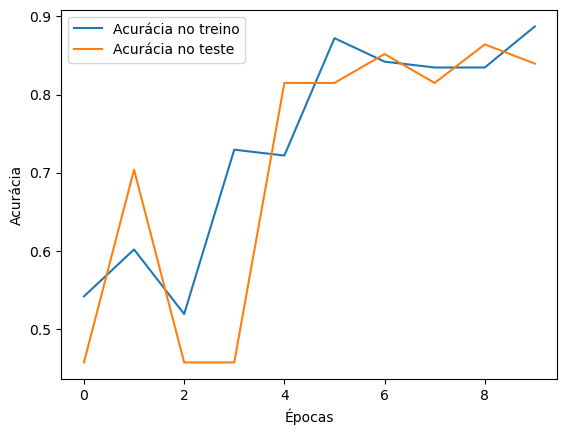

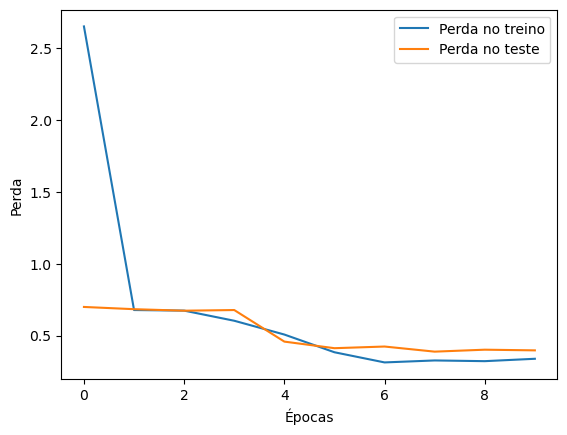

In [25]:
# Fazer previsões sobre as imagens de teste
predictions = model.predict(np.array(test_images))

# Converter as previsões para 0 ou 1
predicted_labels = (predictions >= 0.5).astype(int).flatten()

# Ploto a acurácia
plt.plot(history.history['accuracy'], label='Acurácia no treino')
plt.plot(history.history['val_accuracy'], label='Acurácia no teste')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Ploto a perda
plt.plot(history.history['loss'], label='Perda no treino')
plt.plot(history.history['val_loss'], label='Perda no teste')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# 4. Análise e Visualização dos resultados

## 4.1 Métricas de Desempenho(F1-Score, ROC e AUC-ROC)

F1 Score: 0.88
AUC Score: 0.92


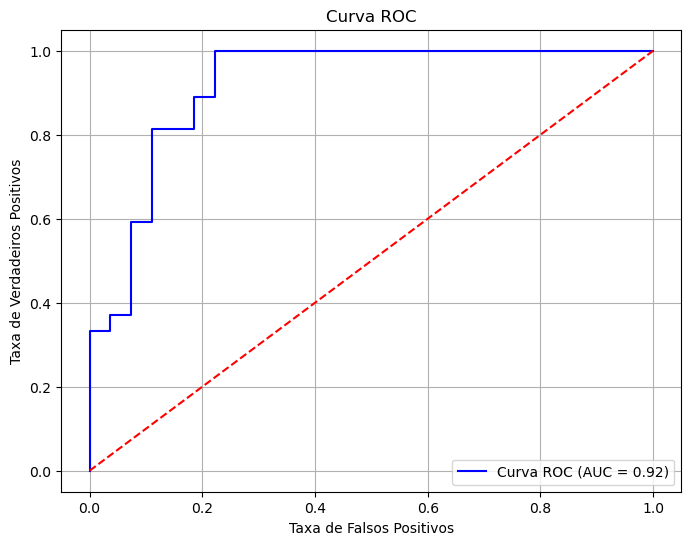

In [28]:

# F1-score
f1 = f1_score(test_labels, predicted_labels)
print(f"F1 Score: {f1:.2f}")

# AUC sem gerar a curva
auc_score = roc_auc_score(test_labels, predictions)

print(f"AUC Score: {auc_score:.2f}")

# Aqui calculo a curva ROC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)

# Aqui é o AUC co base nos pontos gerados acima no roc_curve
roc_auc = auc(fpr, tpr)

# Ploto a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [29]:
# Tabela com as métricas que eu criei
metrics_data = {
    'Métrica': ['Loss (Perda)', 'Acurácia', 'F1-Score', 'AUC'],
    'Valor': [test_loss, test_accuracy, f1, roc_auc]
}
df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))

     Métrica    Valor
Loss (Perda) 0.434819
    Acurácia 0.870370
    F1-Score 0.881356
         AUC 0.919067


**Interpretação:** De acordo com o resultado das métricas, o modelo desenvolvido é bom em equilibrar precision e recall (F1-Score), mas ainda a espaço para melhorias. Ademais, o modelo possui uma boa capacidade de separar corretamentes as classes (faces masculino e faces femininas). Esses resultados mostram que o modelo é confiável e está bem generalizado.

## 4.2 Visualizando Imagens Classificadas de Forma Incorreta

In [32]:
# Pego os indices das imagens classificadas incorretamente
incorrect_indices = np.where(predicted_labels != test_labels)[0]

In [33]:
print(f"Quantidade de imagens classificadas incorretamente: {len(incorrect_indices)}")

Quantidade de imagens classificadas incorretamente: 7


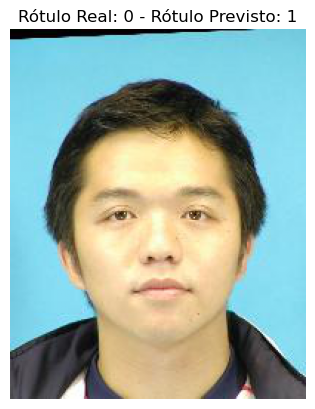

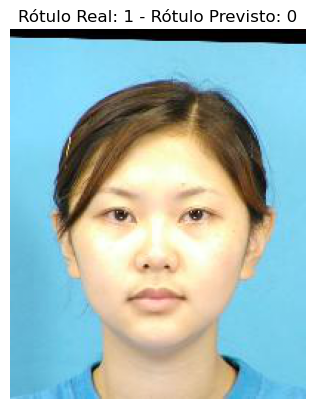

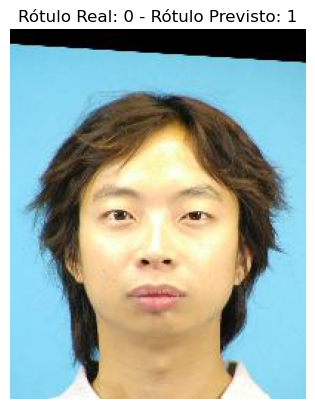

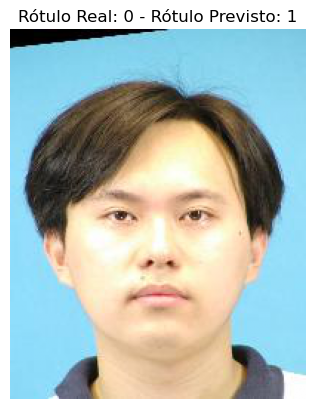

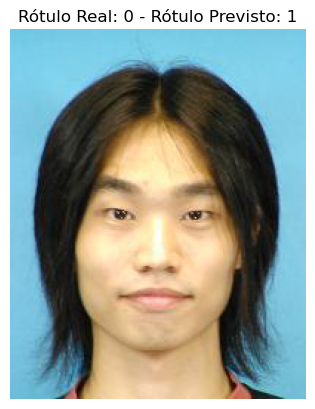

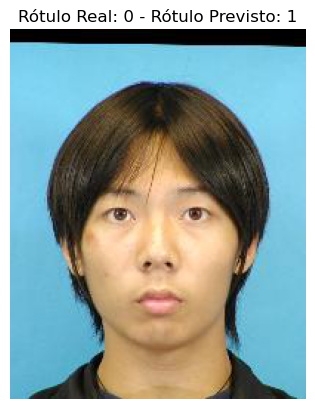

In [34]:
# Visualizo algumas imagens classificadas incorretamente
for inc in incorrect_indices[:6]:  
    plt.imshow(test_images[inc])
    plt.title(f"Rótulo Real: {test_labels[inc]} - Rótulo Previsto: {predicted_labels[inc]}")
    plt.axis('off')
    plt.show()

**Interpretação:** Como balanceei as classes do conjunto de dados, algumas imagens de mulheres estão repetidas. Porém, analisando as possíveis dificuldades que o modelo pode ter em identificar se a face é de um homem ou mulher, percebi que algumas pessoas possuem características ambíguas que não seguem os padrões faciais de gênero. Notei, por exemplo, homens com rostos mais delicados e cabelos longos, e mulheres com traços mais marcantes, especialmente nas bochechas e olhos. Como a quantidade de imagens das classes foi equilibrada, acredito que não haja viés nesse aspecto, mas essas características ambíguas podem ser o que esta gerando essa dificuldade. 